# Hồi quy tuyến tính đa biến với Python

- Thực hành trong bài báo cáo Mutiple regression

Import các thư viện cần sử dụng

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scratch.linear_algebra import dot, Vector
from typing import List
import random
import tqdm
from scratch.linear_algebra import vector_mean
from scratch.gradient_descent import gradient_step
from scratch.simple_linear_regression import total_sum_of_squares
from typing import TypeVar, Callable
from scratch.statistics import median, standard_deviation
from scratch.probability import normal_cdf
from scratch.linear_algebra import add
from scratch.statistics import daily_minutes_good
from scratch.gradient_descent import gradient_step

## Xây dựng thuật toán trong sách

* Giá trị dự đoán 

    - $ \hat y = \beta_0 + \beta_1 x_1 + \dots + \beta_n x_n $
* Sai số 

    - $ \epsilon = y - \hat y $
* Least squares function 

    - $ \displaystyle \mathcal{L} = \sum_{i=1}^N \epsilon^2_i = \sum_{i=1}^N(y_i - \sum_{j=0}^k\beta_jx_{ij})^2 = \Vert y -\beta X \Vert^2_2 $

In [2]:
def predict(x: Vector, beta: Vector) -> float:
    """assumes that the first element of x is 1"""
    return dot(x, beta)
def error(x: Vector, y: float, beta: Vector) -> float:
    return predict(x, beta) - y

def squared_error(x: Vector, y: float, beta: Vector) -> float:
    return error(x, y, beta) ** 2


## Áp dụng Gradient Descent để tìm $\beta$

 * Parameter of model
 
 $\displaystyle \dfrac{\partial \mathcal{L}}{\partial \beta_{j}} = -2\sum_{i=1}^N(y_i - \sum_{j=0}^k\beta_jx_{ij})x_{ij} = 0 $    &emsp; &emsp; $j = 0,1,\dots,k$
 
 * Gradient descent for Mutiple Variables

	$\displaystyle \beta_j := \beta_j - 2\alpha\sum_{i=1}^n(\sum_{j=0}^k\beta_jx_{ij}- y_i)x_{ij}$

In [3]:
def sqerror_gradient(x: Vector, y: float, beta: Vector) -> Vector:
    err = error(x, y, beta)
    return [2 * err * x_i for x_i in x]

In [4]:
def least_squares_fit(xs: List[Vector],
                      ys: List[float],
                      learning_rate: float = 0.001,
                      num_steps: int = 1000,
                      batch_size: int = 1) -> Vector:
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

# Tính R-square

$ R^{2} = \dfrac{SS_{reg}}{SS_{total}} = 1 - \dfrac{SS_{error}}{SS_{total}}$

In [5]:
def multiple_r_squared(xs: List[Vector], ys: Vector, beta: Vector) -> float:
    sum_of_squared_errors = sum(error(x, y, beta) ** 2
                                for x, y in zip(xs, ys))
    return 1.0 - sum_of_squared_errors / total_sum_of_squares(ys)

* Áp dụng phương pháp Bootstrap để tính phân bố của $\beta$

In [6]:
X = TypeVar('X')        # Generic type for data
Stat = TypeVar('Stat')
def bootstrap_sample(data: List[X]) -> List[X]:
    """randomly samples len(data) elements with replacement"""
    return [random.choice(data) for _ in data]

def bootstrap_statistic(data: List[X],
                        stats_fn: Callable[[List[X]], Stat],
                        num_samples: int) -> List[Stat]:
    """evaluates stats_fn on num_samples bootstrap samples from data"""
    return [stats_fn(bootstrap_sample(data)) for _ in range(num_samples)]

In [7]:
def p_value(beta_hat_j: float, sigma_hat_j: float) -> float:
    if beta_hat_j > 0:
        # if the coefficient is positive, we need to compute twice the
        # probability of seeing an even *larger* value
        return 2 * (1 - normal_cdf(beta_hat_j / sigma_hat_j))
    else:
        # otherwise twice the probability of seeing a *smaller* value
        return 2 * normal_cdf(beta_hat_j / sigma_hat_j)

# Hồi quy ridge và hồi quy lasso

* Hồi quy ridge

$\displaystyle \mathcal{L} = \sum_{i=1}^N(y_i - \sum_{j=0}^k\beta_jx_{ij})^2 + \lambda \sum_{j=1}^k\beta_j^2$

* Gradient descent

$\displaystyle \beta_j := \beta_j - 2\alpha(\sum_{i=1}^n(y_i - \sum_{j=0}^k\beta_jx_{ij})x_{ij} + \lambda\beta_j)$

In [8]:
def ridge_penalty(beta: Vector, alpha: float) -> float:
    return alpha * dot(beta[1:], beta[1:])

def squared_error_ridge(x: Vector,
                        y: float,
                        beta: Vector,
                        alpha: float) -> float:
    """estimate error plus ridge penalty on beta"""
    return error(x, y, beta) ** 2 + ridge_penalty(beta, alpha)

def ridge_penalty_gradient(beta: Vector, alpha: float) -> Vector:
    """gradient of just the ridge penalty"""
    return [0.] + [2 * alpha * beta_j for beta_j in beta[1:]]

def sqerror_ridge_gradient(x: Vector,
                           y: float,
                           beta: Vector,
                           alpha: float) -> Vector:
    """
    the gradient corresponding to the ith squared error term
    including the ridge penalty
    """
    return add(sqerror_gradient(x, y, beta),
               ridge_penalty_gradient(beta, alpha))

In [9]:
learning_rate = 0.001
def least_squares_fit_ridge(xs: List[Vector],
                            ys: List[float],
                            alpha: float,
                            learning_rate: float,
                            num_steps: int,
                            batch_size: int = 1) -> Vector:
    # Start guess with mean
    guess = [random.random() for _ in xs[0]]

    for i in range(num_steps):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_ridge_gradient(x, y, guess, alpha)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

## Bộ dữ liệu giá nhà Boston

In [10]:
from sklearn.datasets import load_boston

boston_dataset = load_boston()

boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [11]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [12]:
boston['MEDV'] = boston_dataset.target

In [13]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [15]:
boston.shape

(506, 14)

### Thống kê mô tẩ với pandas và seaborn

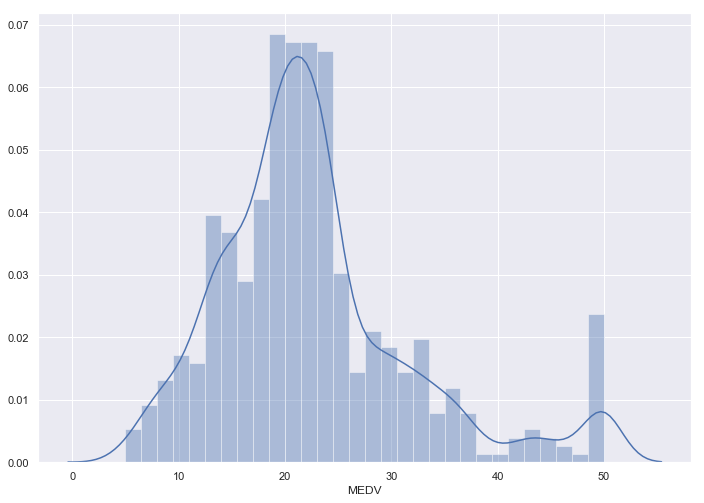

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(boston['MEDV'], bins=30)
plt.show()

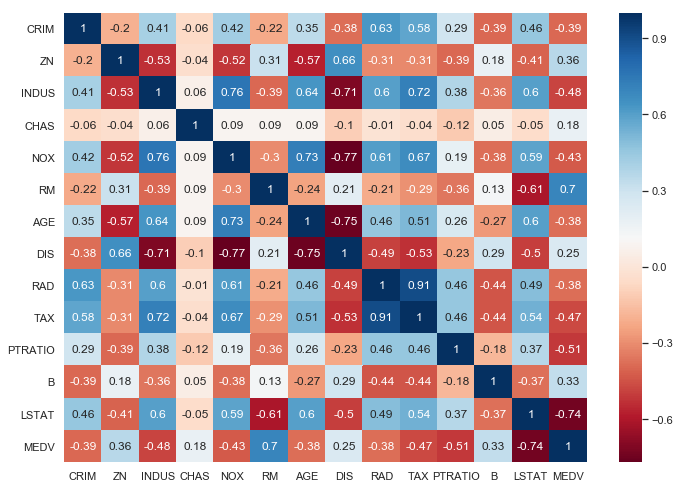

In [17]:
correlation_matrix = boston.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap='RdBu')
plt.show()

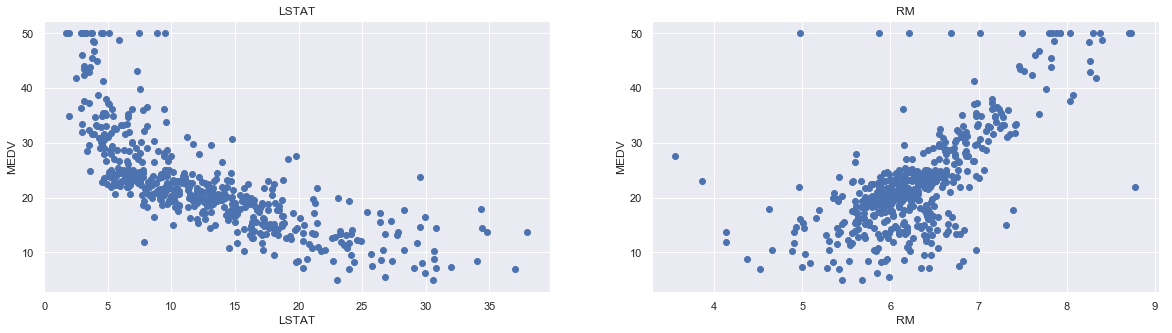

In [18]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

## Chuẩn bị và tách training set và test set

In [19]:
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['MEDV']

In [20]:
from sklearn.model_selection import train_test_split

# splits the training and test data set in 80% : 20%
# assign random_state to any value.This ensures consistency.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


* Chuyển x_train và x_test từ df sang list

In [21]:
X_train_ls=[]
for i in range(X_train.shape[0]):
    X_train_ls.append([1, X_train.iloc[i,0],X_train.iloc[i,1]])
    
X_test_ls=[]
for i in range(X_test.shape[0]):
    X_test_ls.append([1, X_test.iloc[i,0],X_test.iloc[i,1]])

* Chuyển y_train và y_test từ df sang list 

In [22]:
Y_train_ls = Y_train.tolist()
Y_test_ls = Y_test.tolist()

### Training dữ liệu tìm tham số $\beta$

In [23]:
random.seed(0)
beta = least_squares_fit(X_train_ls, Y_train_ls, 0.001, 5000, 25)

least squares fit: 100%|██████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 171.60it/s]


In [24]:
beta

[1.8614819429473808, -0.6314338509058782, 4.738252002998941]

In [25]:
multiple_r_squared(X_train_ls,Y_train_ls, beta)

0.6116416469079261

## Test kết quả với Test set

In [26]:
multiple_r_squared(X_test_ls,Y_test_ls, beta)

0.6694026319767057

### Diễn giải kết quả 

* Tìm được các tham số:

$\beta_0 \approx 1.8, \beta_1 \approx -0.63, \beta_2 \approx 4.7$


* Phương trình hồi quy:

$ y \approx 1.8 - 0.63x_1 + 4.7x_2$



* R- square (Ở training set): 
$R^2 \approx 0.61$
* R- square (Ở test set):
$R^2 \approx 0.67$, khá ổn

## Sử dụng SK-Learn

* Training dataset với SK-Learn 

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set

y_test_predict = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 5.6371293350711955
R2 score is 0.6300745149331701


The model performance for testing set
--------------------------------------
RMSE is 5.137400784702912
R2 score is 0.6628996975186952


In [30]:
y_test_predict= []
for i in range(X_test.shape[0]):
    y_test_predict.append(predict(X_test_ls[i],beta))

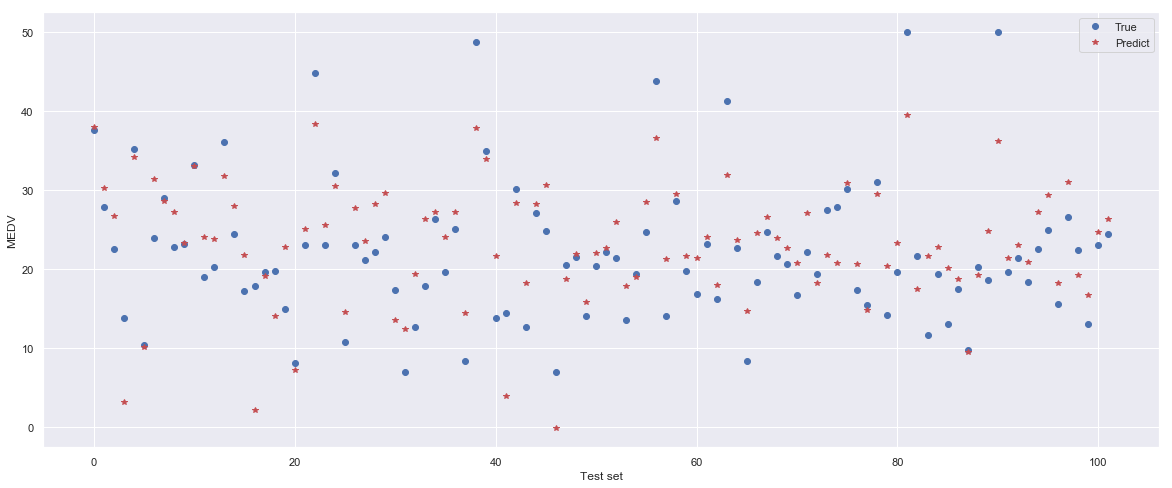

In [31]:
ax, fig = plt.subplots(figsize=(20,8))
plt.plot(np.arange(len(Y_test)),Y_test, 'b.', marker='o')
plt.plot(np.arange(len(y_test_predict)),y_test_predict, 'r.', marker='*')
plt.legend(["True","Predict"])
plt.ylabel("MEDV")
plt.xlabel("Test set")
plt.show()

## Áp dụng Hồi quy Ridge với từng hệ số $\lambda$

* Với $\lambda =0 $ (hi vọng kết quả ra giống hồi quy bình thường)

In [32]:
beta_0 = least_squares_fit_ridge(X_train_ls, Y_train_ls, 0.0, 0.001, 5000, 25)

In [33]:
beta_0

[1.661083434699009, -0.6295470190670965, 4.766152477862312]

In [34]:
multiple_r_squared(X_test_ls, Y_test_ls, beta_0)

0.6699967622420033

In [35]:
beta_0_1 = least_squares_fit_ridge(X_train_ls, Y_train_ls, 0.1, 0.001, 5000, 25)

In [36]:
beta_0_1

[7.731246998698442, -0.6739589556535959, 3.8875056620311725]

In [37]:
multiple_r_squared(X_test_ls, Y_test_ls, beta_0_1)

0.6523081850456433

In [38]:
beta_1 = least_squares_fit_ridge(X_train_ls, Y_train_ls, 1, 0.001, 5000, 25)

In [39]:
beta_1

[26.108657842254694, -0.8091827462841509, 1.2369116773303783]

In [40]:
multiple_r_squared(X_test_ls, Y_test_ls, beta_1)

0.5637862963648861

# Kết luận sau bài thực hành

* Hồi quy tuyến tính trong sách thực hiện khá tốt dự báo giá nhà
* Hồi quy ridge cần lựa chọn khi có một tham số có giá trị cao (mô hình bị overfitting), ở đây mô hình không bị nên:
    - $\lambda =0$ (mô hình trở về bình thường).
    - $\lambda =1$ (tham số lớn càng có giá trị càng lớn càng giảm).
    
     $\rightarrow$ Mô hình hồi quy Ridge có giá trị dự báo thấp hơn bình thường.
* Cần làm:
    - Xây dựng mô hình với nhiều biến
    - Xử dụng hồi quy lasso

# Reference
1. [Linear Regression on Boston Housing Dataset](https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155)